In [1]:
!pip3 install xgboost

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# IMPORTANDO LIBRERÍAS

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.plotly as py

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

from itertools import product
import itertools
from collections import OrderedDict
import operator
import re
from math import sqrt
import pickle

# DATAFRAME

In [4]:
fifasup=pd.read_csv('prediction.csv')
fifasup.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,158023,L. Messi,RF,31,173.727522,72.137028,Left,4.0,Argentina,America,...,64,61,61,61,64,59,47,47,47,59
1,20801,Cristiano Ronaldo,ST,33,188.966778,83.025636,Right,4.0,Portugal,Europe,...,65,61,61,61,65,61,53,53,53,61
2,190871,Neymar Jr,LW,26,179.823225,68.053800,Right,5.0,Brazil,America,...,65,60,60,60,65,60,47,47,47,60
3,193080,De Gea,GK,27,195.062481,76.220256,Right,3.0,Spain,Europe,...,50,50,50,50,50,50,50,50,50,50
4,192985,K. De Bruyne,RCM,27,155.745200,69.868568,Right,5.0,Belgium,Europe,...,77,77,77,77,77,73,66,66,66,73


# AGRUPACIÓN DE DATOS

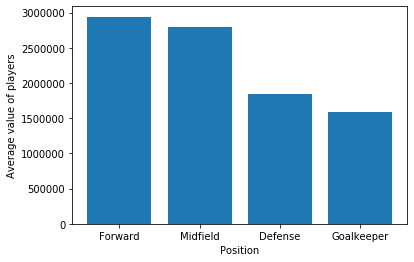

In [5]:
#Player value per position
positions = {
    'Forward' : ['CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW', 'ST'],
    'Midfield' : ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'RAM', 'RCB', 'RCM', 'RDM', 'RM'],
    'Defense' : ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB'],
    'Goalkeeper' : ['GK'],
}
count_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
players_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
position_avg = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}

def add_values(series):
    already_counted = [0, 0, 0, 0]
    preferred_position_list = re.sub("[^\w]", " ",  series[0]).split() #Split the preferred positions
    value = series[1]

    #Count the players per position category
    index = 0
    for preferred_position in preferred_position_list:
        for position in positions:
            if preferred_position in positions[position]:
                if(not already_counted[index]):
                    count_position[position] += value
                    players_position[position] += 1                    
                    already_counted[index] = 1
                    
position_value = fifasup[['Position', 'Value(€M)']]
position_value.apply(add_values, 1)

#Average the players value per position category
for position in count_position:
    position_avg[position] = count_position[position] / players_position[position]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.bar(range(len(position_avg)), list(position_avg.values()))
plt.xticks(range(len(position_avg)), list(position_avg.keys()))
plt.xlabel('Position')
plt.ylabel('Average value of players')
plt.show()

Como podemos observar, las posiciones con mayor cantidad de jugadores son **Delanteros** y **Mediocampistas**.

# MODELOS PREDICTIVOS

Estableceremos un modelo de machine learning para intentar predecir el **valor de mercado** de una jugadora y el **salario** que debería de recibir con base en sus características individuales.

Es importante mencionar que la **nacionalidad** y el **club** son variables que por sí solas genera una brecha salarial y mercado.

In [6]:
fifasup_mach = fifasup.copy()
fifasup_mach = fifasup_mach.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifasup_mach = fifasup_mach.drop(fifasup_mach.columns[0], axis = 1)

In [8]:
fifaw_value=pd.read_csv('wdata.csv')
fifaw_value.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [9]:
fifaw_value = fifaw_value.copy()
fifaw_value = fifaw_value.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_value = fifaw_value.drop(fifaw_value.columns[0], axis = 1)

In [10]:
fifaw_wage=pd.read_csv('wdata.csv')
fifaw_wage.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [11]:
fifaw_wage = fifaw_wage.copy()
fifaw_wage = fifaw_wage.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_wage = fifaw_wage.drop(fifaw_wage.columns[0], axis = 1)

In [12]:
y_valuew = fifaw_value['Value(€M)'].copy()
fifaw_value = fifaw_value.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [13]:
y_wagew = fifaw_wage['Wage(€K)'].copy()
fifaw_wage = fifaw_wage.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [14]:
y_value = fifasup_mach['Value(€M)'].copy()
y_wage = fifasup_mach['Wage(€K)'].copy()
fifasup_mach = fifasup_mach.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [15]:
def count_positions(position):
    return len(re.sub("[^\w]", " ",  position).split())

In [16]:
fifasup_mach['Versatility'] = fifasup_mach['Position'].apply(count_positions)
fifasup_mach.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,RF,31,173.727522,72.137028,4.0,5.0,94,94,0,226500000.0,...,61,61,61,64,59,47,47,47,59,1
1,ST,33,188.966778,83.025636,4.0,5.0,94,94,0,127100000.0,...,61,61,61,65,61,53,53,53,61,1
2,LW,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,...,60,60,60,65,60,47,47,47,60,1
3,GK,27,195.062481,76.220256,3.0,4.0,91,93,2,138600000.0,...,50,50,50,50,50,50,50,50,50,1
4,RCM,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,...,77,77,77,77,73,66,66,66,73,1


In [17]:
fifaw_value['Versatility'] = fifaw_value['Position'].apply(count_positions)
fifaw_value.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [18]:
fifaw_wage['Versatility'] = fifaw_wage['Position'].apply(count_positions)
fifaw_wage.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [19]:
fifasup_mach['Versatility'].unique()

array([1])

In [20]:
fifasup_mach = fifasup_mach.drop(['Position'], axis = 1)

In [21]:
fifaw_value = fifaw_value.drop(['Position'], axis = 1)

In [22]:
fifaw_wage = fifaw_wage.drop(['Position'], axis = 1)

**Boosting** aplica un proceso iterativo donde en lugar de entrenar a todos los modelos de forma aislada cada nuevo modelo se entrena para corregir los errores cometidos por los anteriores. Es decir, los modelos se van agregando de forma secuencialmente hasta que no se puedan realizar más mejoras.

Empezaremos por crear un train-test-split donde el entrenamiento tome el 80% de los datos y el test el restante 20%.

**XGBoost** requiere que la información se presente de una forma particular denominada **DMatrix**. Es una transformación linear de los datos, pero es requerida.

Los parámetros más simples son **max_depth** (profundidad máxima de los árboles de decisión que se están entrenando), **objective** (la función de pérdida utilizada) y **num_class** (el número de clases en el conjunto de datos). El parámetro **eta** tiene una interpretación especial.


**Gradient Boosting** implica crear y agregar árboles de decisión a un modelo de conjunto secuencialmente. Se crean nuevos árboles para corregir los errores residuales en las predicciones del conjunto existente. Tener varios modelos juntos para formar uno muy grande y complicado puede generar que esta técnica sea propensa al **overfitting**. El parámetro **eta** nos permite evitar este problema, ya que se puede considerarlo como una tasa de aprendizaje. 

En lugar de simplemente agregar las predicciones de nuevos árboles al conjunto con todo el peso, el eta se multiplicará por los residuos que se agregan para reducir su peso. Esto reduce efectivamente la complejidad del modelo general.

Es común tener valores pequeños en el rango de **0.1 a 0.3**. La menor ponderación de estos residuos todavía nos ayudará a entrenar un modelo poderoso, pero no permitirá que ese modelo se escape a una complejidad profunda donde es más probable que ocurra un **overfitting**.

La información para adaptar mi modelo https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f 

# MODELO 1: Predicción del valor de mercado

In [23]:
X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(fifasup_mach, y_value, test_size=0.2)

In [24]:
num_boost_round = 999
early_stopping_rounds = 10

xgb_params = {
                'n_estimators':[500],
                'objective':['reg:linear'],
                'eval_metric':[ ["rmse" ,"mae"]],
                'min_child_weight': [1],
                'eta': [0.01, 0.1], 
                'gamma': [0.05, 0.1],  
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0],
               'max_depth': [6, 9]
              }

params_perms = [dict(zip(xgb_params, v)) for v in product(*xgb_params.values())]
print(len(params_perms))
print(params_perms[0])

NameError: name 'xgb_params' is not defined

In [ ]:
dtrain_value = xgb.DMatrix(X_train_value, label=y_train_value)
dtest_value = xgb.DMatrix(X_test_value, label=y_test_value)
evaluation_set_value = [(dtest_value, "Test_set")]

In [ ]:
mean_train_value = np.mean(y_train_value)

baseline_predictions_value = np.ones(y_test_value.shape) * mean_train_value

mae_baseline_value = mean_absolute_error(y_test_value, baseline_predictions_value)

rmse_baseline_value = sqrt(mean_squared_error(y_test_value, baseline_predictions_value))

print("Baseline MAE is {:.2f}".format(mae_baseline_value))
print("Baseline RMSE is {:.2f}".format(rmse_baseline_value))

In [ ]:
best_score_value = mae_baseline_value
best_params_value = {}
for i, grid_search_value in enumerate(params_perms):
    print("Permutation number:", i+1)
    cv_results_value = xgb.cv(grid_search_value,
                        dtrain_value,
                       num_boost_round=num_boost_round,
                      seed=42,
                     nfold=2,
                    metrics=['mae', 'rmse'],
                   early_stopping_rounds=early_stopping_rounds
                  )
    
    mean_mae_value = cv_results_value['test-mae-mean'].min()
    boost_rounds_value = cv_results_value['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae_value, boost_rounds_value))
    if mean_mae_value < best_score_value:
        best_score_value = mean_mae_value
        best_params_value = grid_search_value

In [ ]:
print("Best Score:", best_score_value)
print("Best Parameters:", best_params_value)

In [ ]:
#Retrain a model with new best params
model_value = xgb.train(
    best_params_value,
    dtrain_value,
    num_boost_round=num_boost_round,
    evals=evaluation_set_value,
    early_stopping_rounds=early_stopping_rounds
 )

In [ ]:
print("Average guess error", mae_baseline_value)
print("vs Mean Absolute Error", mean_absolute_error(model_value.predict(dtest_value), y_test_value))

In [ ]:
#!#Predict the value based on the model.
dpred_value = xgb.DMatrix(fifasup_mach, label = y_value)
y_pred = pd.Series(model_value.predict(dpred_value))

In [ ]:
#!#Top 10% players with overpriced transfer values.
sub_value = y_value.subtract(y_pred)
exp_value = fifasup_mach.loc[sub_value.nlargest(int(len(sub_value)/1000)).index]
exp_value

In [ ]:
#Top 10% players with underpriced transfer values.
cheap_value = sub_value.nsmallest(int(len(sub_value)/1000))
cheap_value = fifasup_mach.loc[cheap_value.index]
cheap_value

In [ ]:
model_value.save_model("model_value.model")

In [ ]:
fifasup_mach.columns

In [ ]:
fifaw_value.shape

In [ ]:
loaded_modelv = xgb.Booster()
loaded_modelv.load_model("model_value.model")

In [ ]:
fifaw_value['Value(€M)'] = loaded_modelv.predict(xgb.DMatrix(fifaw_value))

In [ ]:
exchange_rate = 21.1473

In [ ]:
fifaw_value['Value($M)'] = fifaw_value['Value(€M)'] * exchange_rate

In [ ]:
fifaw_value

# MODELO 2: Predicción del salario

In [ ]:
X_train_wage, X_test_wage, y_train_wage, y_test_wage = train_test_split(fifasup_mach, y_wage, test_size=0.2)

In [ ]:
dtrain_wage = xgb.DMatrix(X_train_wage, label=y_train_wage)
dtest_wage = xgb.DMatrix(X_test_wage, label=y_test_wage)
evaluation_set_wage = [(dtest_wage, "Test_set")]

In [ ]:
mean_train_wage = np.mean(y_train_wage)

baseline_predictions_wage = np.ones(y_test_wage.shape) * mean_train_wage

mae_baseline_wage = mean_absolute_error(y_test_wage, baseline_predictions_wage)

rmse_baseline_wage = sqrt(mean_squared_error(y_test_wage, baseline_predictions_wage))

print("Baseline MAE is {:.2f}".format(mae_baseline_wage))
print("Baseline RMSE is {:.2f}".format(rmse_baseline_wage))

In [ ]:
best_score_wage = mae_baseline_wage
best_params_wage = {}
for i, grid_search_wage in enumerate(params_perms):
    print("Permutation number:", i+1)
    cv_results_wage = xgb.cv(grid_search_wage,
                        dtrain_wage,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=2,
                        metrics=['mae', 'rmse'],
                        early_stopping_rounds=early_stopping_rounds
                        )
    
    mean_mae_wage = cv_results_wage['test-mae-mean'].min()
    boost_rounds_wage = cv_results_wage['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae_wage, boost_rounds_wage))
    if mean_mae_wage < best_score_wage:
        best_score_wage = mean_mae_wage
        best_params_wage = grid_search_wage

In [ ]:
#!#Retrain a model with new best params
model_wage = xgb.train(
    best_params_wage,
    dtrain_wage,
    num_boost_round=num_boost_round,
    evals=evaluation_set_wage,
    early_stopping_rounds=early_stopping_rounds
)

In [ ]:
print("Average guess error", mae_baseline_wage)
print("vs Mean Absolute Error", mean_absolute_error(model_wage.predict(dtest_wage), y_test_wage))

In [ ]:
#!#Predict the value based on the model.
dpred_wage = xgb.DMatrix(fifasup_mach, label = y_wage)
y_pred_wage = pd.Series(model_wage.predict(dpred_wage))

In [ ]:
#!#Top 10% players with overpriced wages.
sub_wage = y_value.subtract(y_pred_wage)
exp_wage = fifasup_mach.loc[sub_wage.nlargest(int(len(sub_wage)/1000)).index]
exp_wage

In [ ]:
#!#Top 10% players with underpriced transfer values.
cheap_wage = sub_wage.nsmallest(int(len(sub_wage)/1000))
cheap_wage = fifasup_mach.loc[cheap_wage.index]
cheap_wage

In [ ]:
model_wage.save_model("model_wage.model")

In [ ]:
loaded_modelw = xgb.Booster()
loaded_modelw.load_model("model_wage.model")

In [ ]:
fifaw_wage['Wage(€K)'] = loaded_modelw.predict(xgb.DMatrix(fifaw_wage))

In [ ]:
exchange_rate = 21.1473

In [ ]:
fifaw_wage['Wage($K)'] = (fifaw_wage['Wage(€K)'] * exchange_rate)/1000000

In [ ]:
fifaw_wage['WageM($K)'] = (fifaw_wage['Wage($K)']/12)*1000

In [ ]:
fifaw_wage

In [ ]:
df_names = pd.read_csv('wdata.csv')

In [ ]:
df_names = df_names[['Name']]

In [ ]:
fifaw_wage = fifaw_wage.join(df_names)

In [ ]:
fifaw_value = fifaw_value.join(df_names)

In [ ]:
fifaw_wage = fifaw_wage.set_index('Name')

In [ ]:
fifaw_wage.to_csv('fifaw_wage_pred', encoding='utf-8', index=False)

In [25]:
fifaw_value = fifaw_value.set_index('Name')

KeyError: "None of ['Name'] are in the columns"

In [ ]:
fifaw_value.to_csv('fifaw_value_pred', encoding='utf-8', index=False)

In [ ]:
xgb.plot_tree(bst, num_trees=32)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')